In [26]:
# Core packages
import os
import time
from datetime import datetime, timedelta

# Data manipulation
import numpy as np
import pandas as pd

# Data sources
import yfinance as yf
import json

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Plot settings
%matplotlib inline
sns.set(rc={"figure.figsize": (12, 6)})

# ML / Stats (optional depending on modeling needs)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report


# Paths
RAW_DATA_DIR = "../data/raw/"
PROCESSED_DATA_DIR = "../data/processed/"
PLOTS_DIR = "../plots/"

In [27]:
#load ticker metadata
with open("../ticker_info.json", "r") as f:
    ticker_info = json.load(f)

# Load cleaned data
file_path = f"{PROCESSED_DATA_DIR}multi_asset_5yr_data_cleaned.csv"
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

# Confirm structure
print(df.shape)
print(df.columns)
df.head()

(1826, 35)
Index(['Close_AAPL', 'Close_BTC-USD', 'Close_EPD', 'Close_GOOGL', 'Close_MSFT',
       'Close_TLT', 'Close_XLE', 'High_AAPL', 'High_BTC-USD', 'High_EPD',
       'High_GOOGL', 'High_MSFT', 'High_TLT', 'High_XLE', 'Low_AAPL',
       'Low_BTC-USD', 'Low_EPD', 'Low_GOOGL', 'Low_MSFT', 'Low_TLT', 'Low_XLE',
       'Open_AAPL', 'Open_BTC-USD', 'Open_EPD', 'Open_GOOGL', 'Open_MSFT',
       'Open_TLT', 'Open_XLE', 'Volume_AAPL', 'Volume_BTC-USD', 'Volume_EPD',
       'Volume_GOOGL', 'Volume_MSFT', 'Volume_TLT', 'Volume_XLE'],
      dtype='object')


,Close_AAPL,Close_BTC-USD,Close_EPD,Close_GOOGL,Close_MSFT,Close_TLT,Close_XLE,High_AAPL,High_BTC-USD,High_EPD,...,Open_MSFT,Open_TLT,Open_XLE,Volume_AAPL,Volume_BTC-USD,Volume_EPD,Volume_GOOGL,Volume_MSFT,Volume_TLT,Volume_XLE
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-07,NaN,11601.472656,NaN,NaN,NaN,NaN,NaN,NaN,11898.038086,NaN,...,NaN,NaN,NaN,NaN,2.313231e+10,NaN,NaN,NaN,NaN,NaN
2020-08-08,NaN,11754.045898,NaN,NaN,NaN,NaN,NaN,NaN,11800.064453,NaN,...,NaN,NaN,NaN,NaN,1.757206e+10,NaN,NaN,NaN,NaN,NaN
2020-08-09,NaN,11675.739258,NaN,NaN,NaN,NaN,NaN,NaN,11806.056641,NaN,...,NaN,NaN,NaN,NaN,1.748961e+10,NaN,NaN,NaN,NaN,NaN
2020-08-10,109.776489,11878.111328,12.533845,74.394829,199.521301,146.511841,31.332096,110.796568,12045.140625,12.615990,...,202.797952,147.464797,30.620930,212403600.0,2.611411e+10,6863700.0,20546000.0,36716500.0,6408500.0,26308100.0
2020-08-11,106.511749,11410.525391,12.451701,73.585693,194.855453,144.770477,31.225826,109.537898,11932.710938,12.848732,...,198.477016,144.822454,31.945166,187902400.0,2.703978e+10,7558200.0,31098000.0,36446500.0,19234200.0,26513100.0


In [29]:
#use dictionary to filter by type
def get_asset_subset(df, ticker_info, asset_type="equity", price_type="Close"):
    tickers = [k for k, v in ticker_info.items() if v["type"] == asset_type]
    cols = [f"{price_type}_{t}" for t in tickers]
    subset = df[cols]
    
    #Rename columns: "CLOSE_AAPL" --> "AAPL"
    subset.columns = [col.split("_")[-1] for col in subset.columns]

    return subset

#create filters for stock type
df_close_equity = get_asset_subset(df, ticker_info, asset_type="equity")
df_close_etf = get_asset_subset(df, ticker_info, asset_type="etf")
df_close_crypto = get_asset_subset(df, ticker_info, asset_type="crypto")

print(df_close_equity.columns)
print(df_close_etf.columns)
print(df_close_crypto.columns)


Index(['AAPL', 'MSFT', 'GOOGL', 'EPD'], dtype='object')
Index(['TLT', 'XLE'], dtype='object')
Index(['BTC-USD'], dtype='object')


In [51]:
#plot actual vs normalized prices
def plot_prices(df_subset, title, window='5y', normalize=True, save=False):
    
    #Plots actual or normalized prices over a specified time window
    #Parameters:
    #-df_subset: DataFrame of prices
    #-title: Title for the plot
    #-window: '5y', '1y', or '30d'
    #-normalize: If True, normalize prices to start at 100
    
    #filter by time window
    if window == '1y':
        days = 365
        end_date = df_subset.index.max()
        start_date = end_date - pd.Timedelta(days=days)
        df_subset = df_subset.loc[start_date:end_date]
    elif window == '30d':
        days = 30
        end_date = df_subset.index.max()
        start_date = end_date - pd.Timedelta(days=days)
        df_subset = df_subset.loc[start_date:end_date]
    
    #drop rows with all NaNs to avoid blank plots
    df_subset = df_subset.dropna(how='all')
    
    #normalize if specified
    if normalize:
        first_valid = df_subset.iloc[0]
        first_valid[first_valid == 0] = 1e-9 #prevent divide by zero
        df_plot = df_subset / df_subset.iloc[0] * 100
        ylabel = "Normalized Price (Start = 100)"
        suffix = "normalized"
    else:
        df_plot = df_subset.copy()
        ylabel = "Price (USD)"
        suffix = "actual"
    
    df_plot.plot(figsize=(12,6))
    plt.title(f"{'Normalized' if normalize else 'Actual'} Price - {title}({window.upper()})", fontsize=16)
    plt.ylabel(ylabel)
    plt.xlabel("Date")
    plt.grid(True)
    plt.legend(title="Ticker")
    plt.tight_layout()
    
    if save:
        os.makedirs(PLOTS_DIR, exist_ok=True)
        filename = f"{title.lower().replace(' ', '_')}_{window}_{suffix}.png"
        plt.savefig(f"{PLOTS_DIR}{filename}")
        
        
    plt.show()

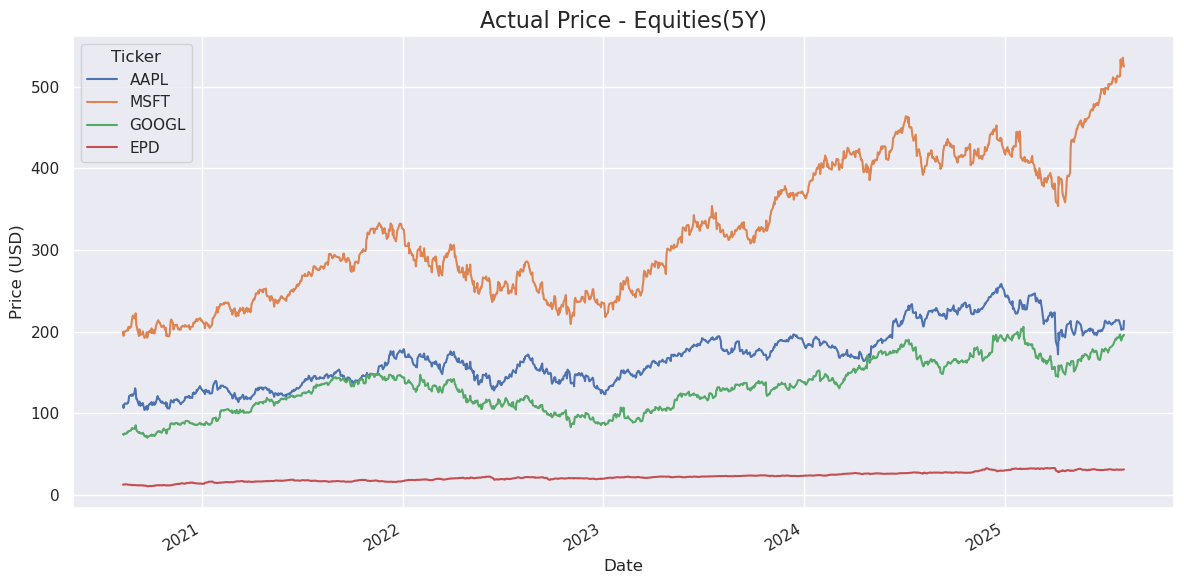

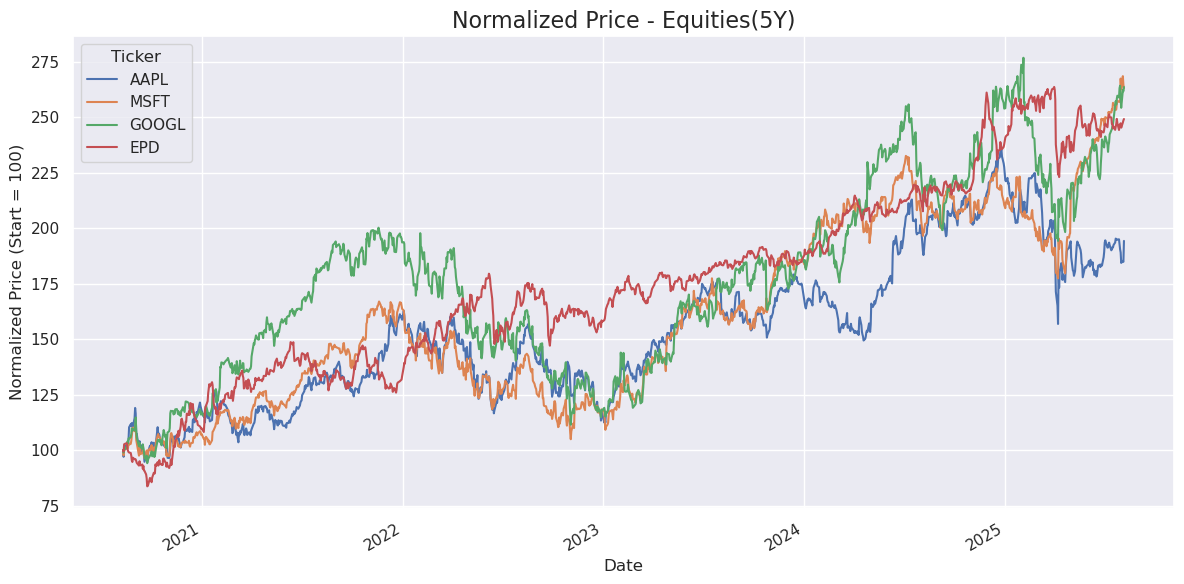

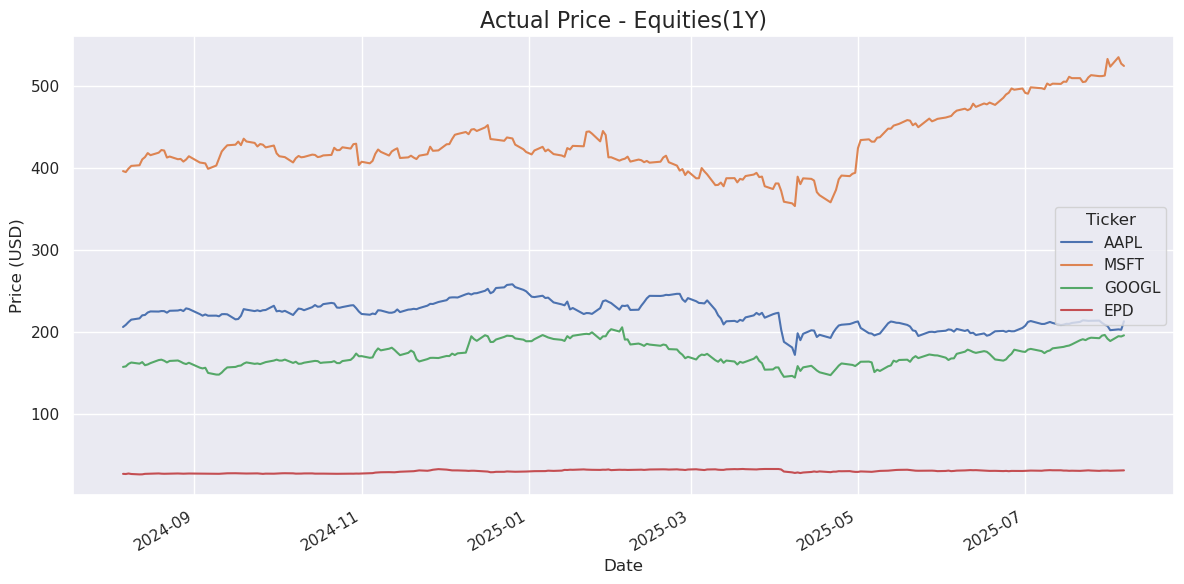

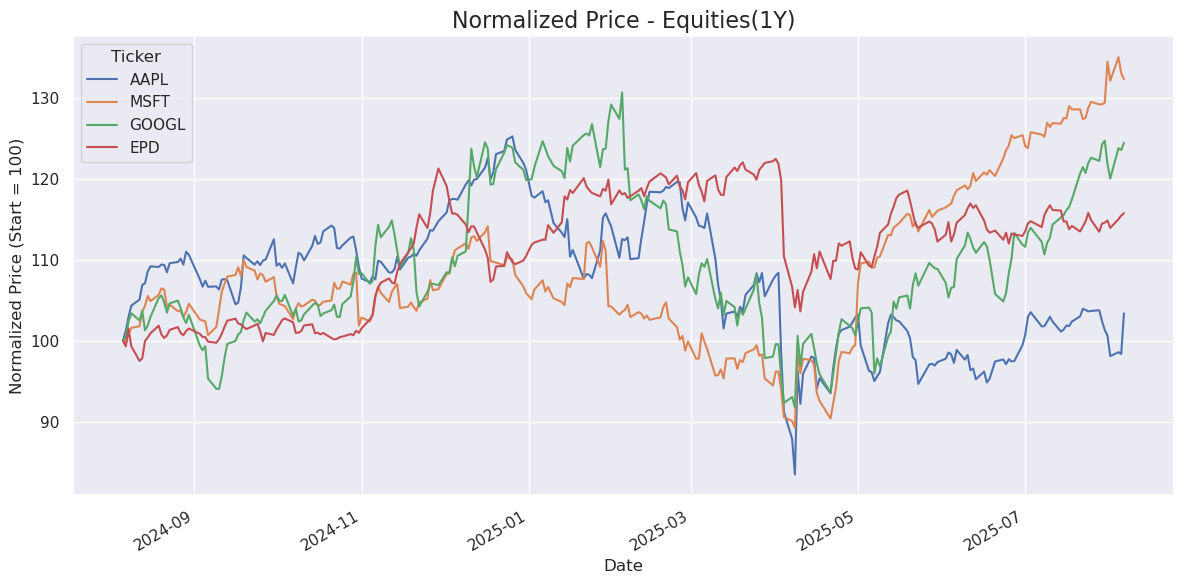

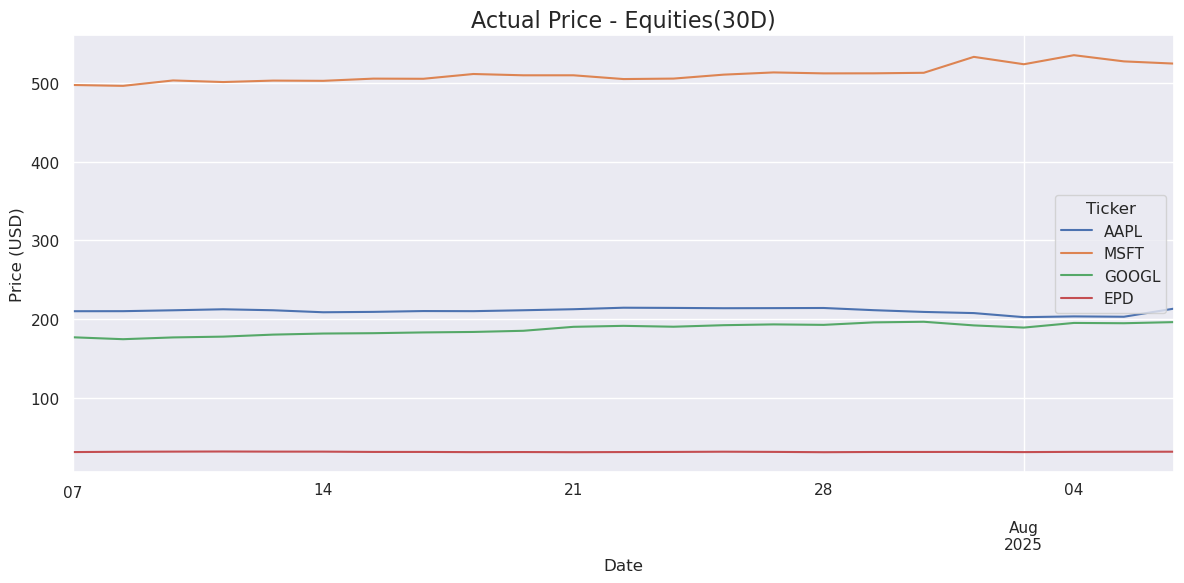

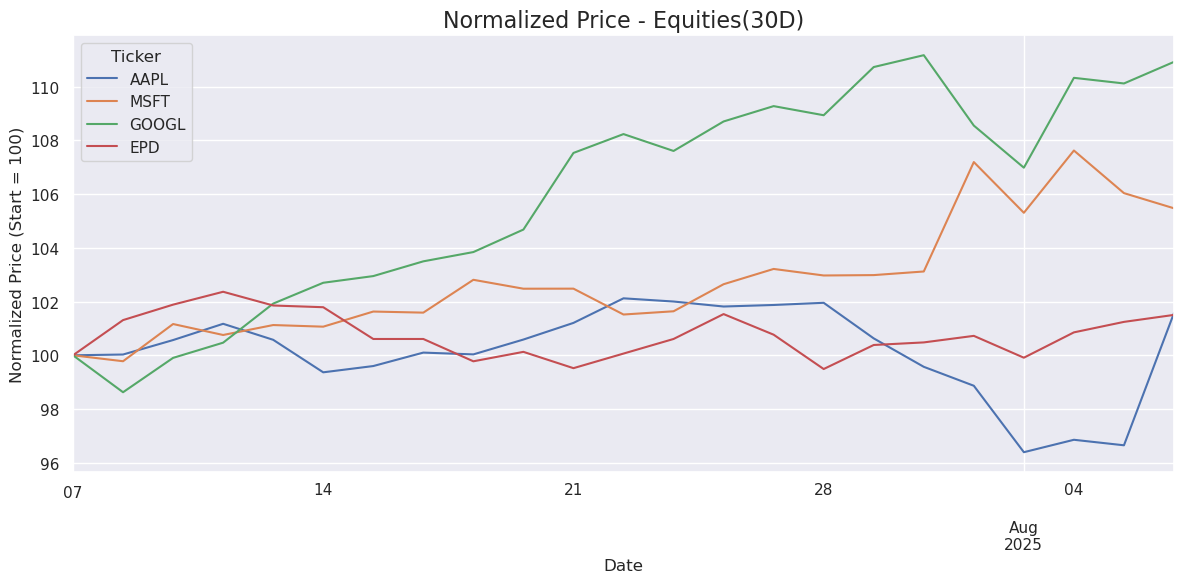

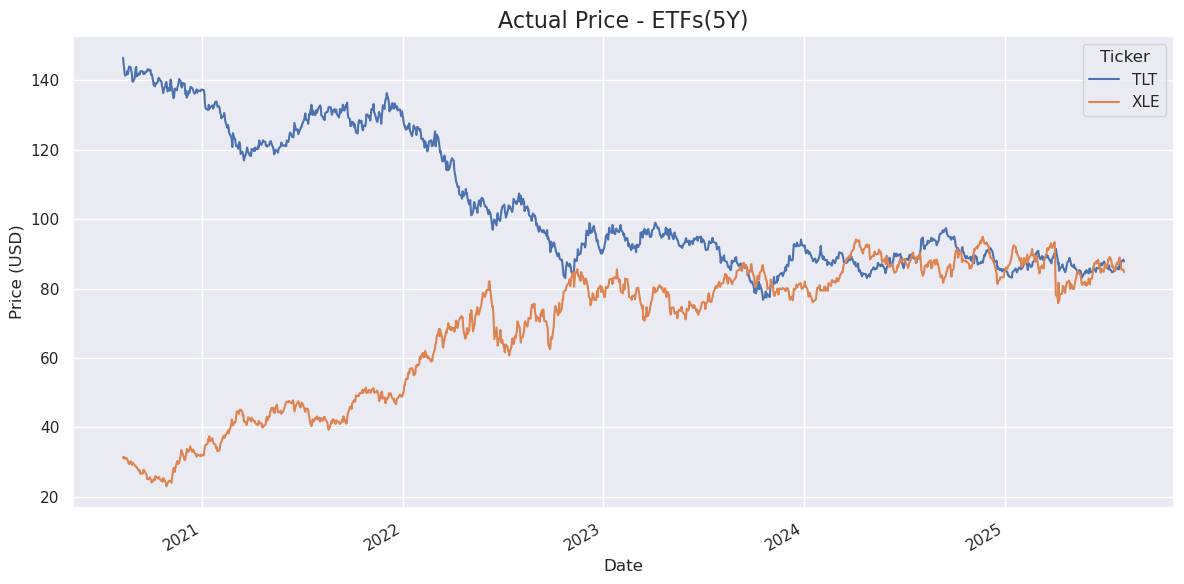

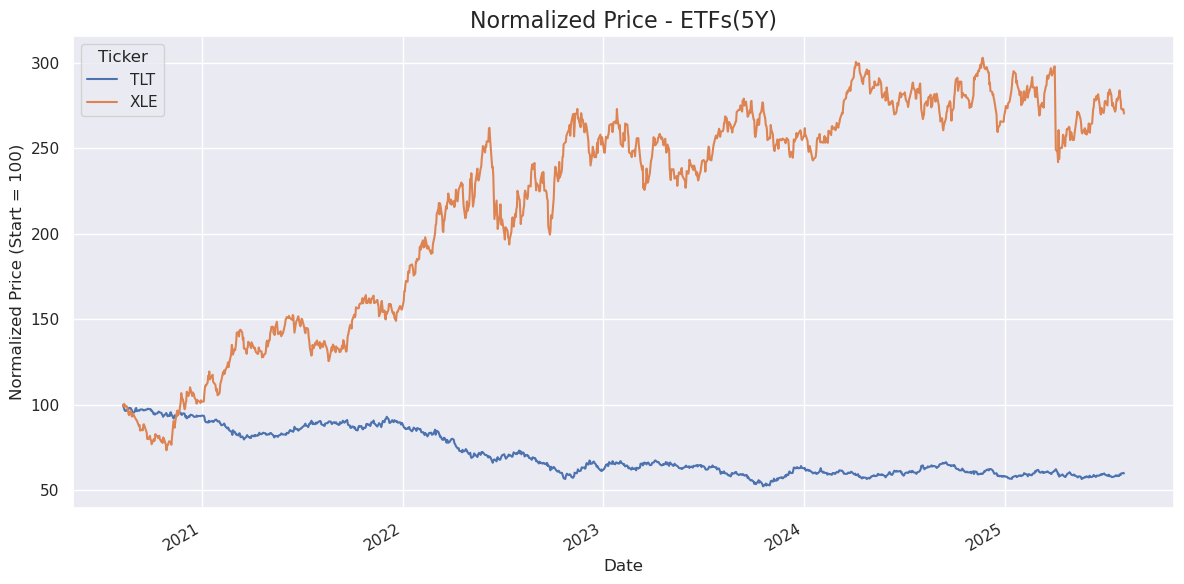

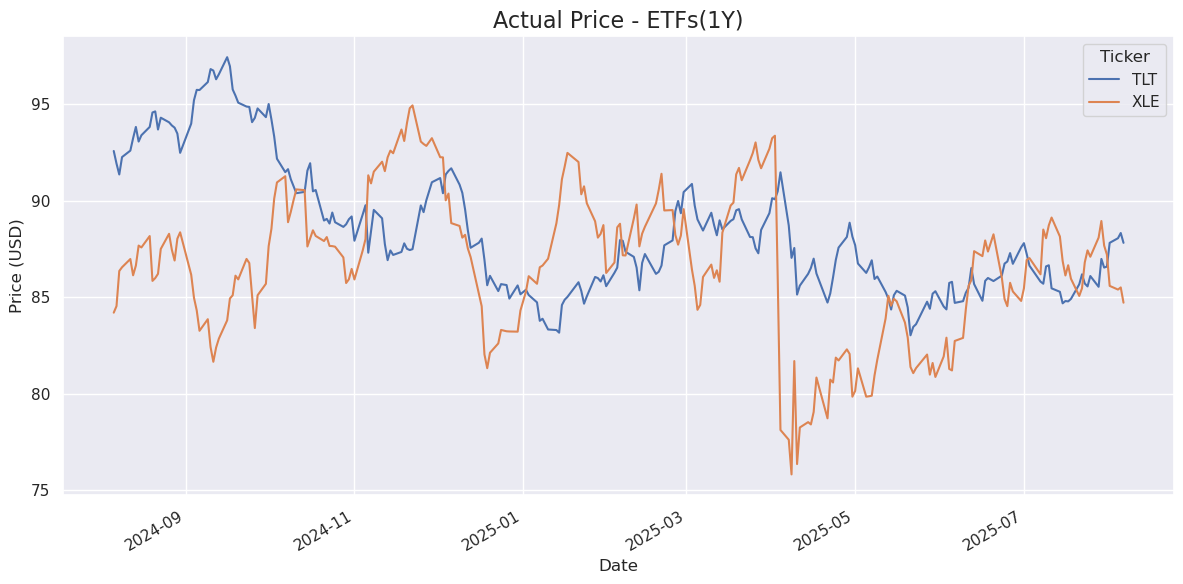

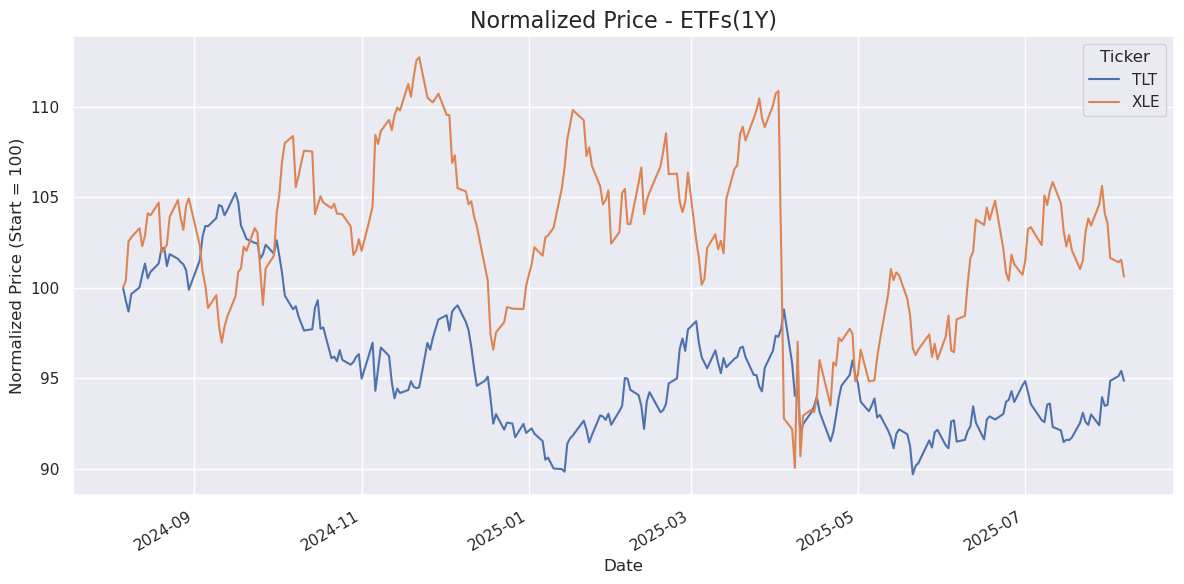

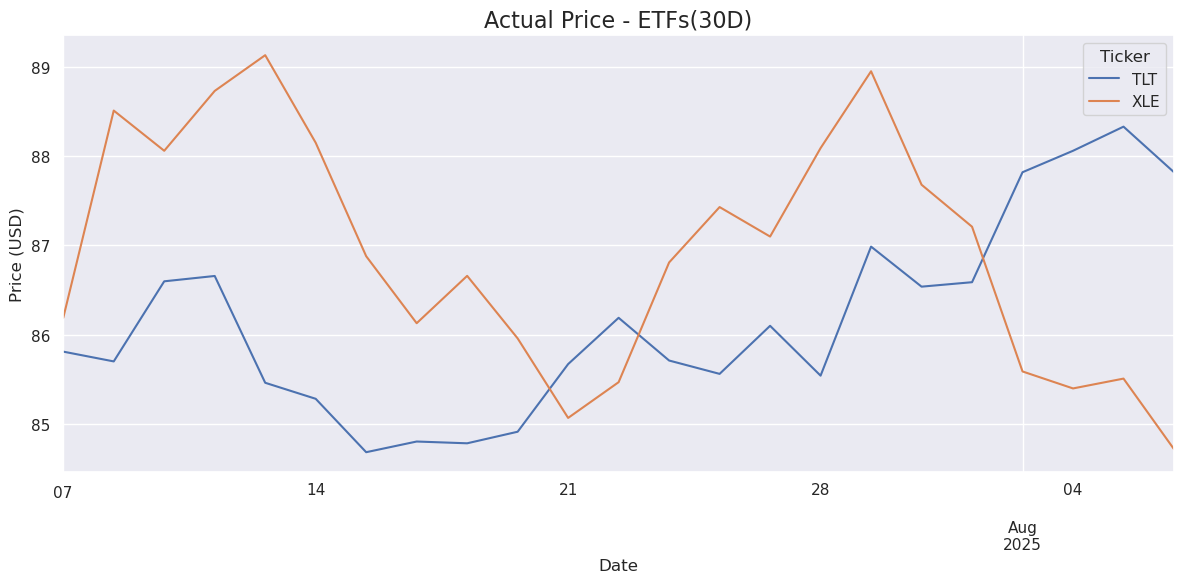

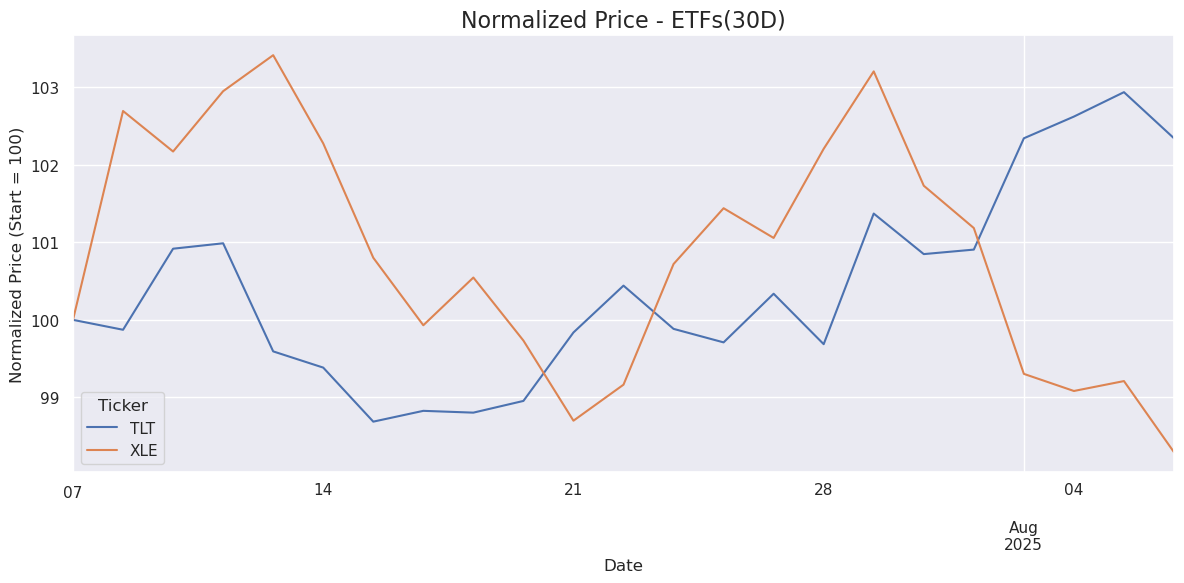

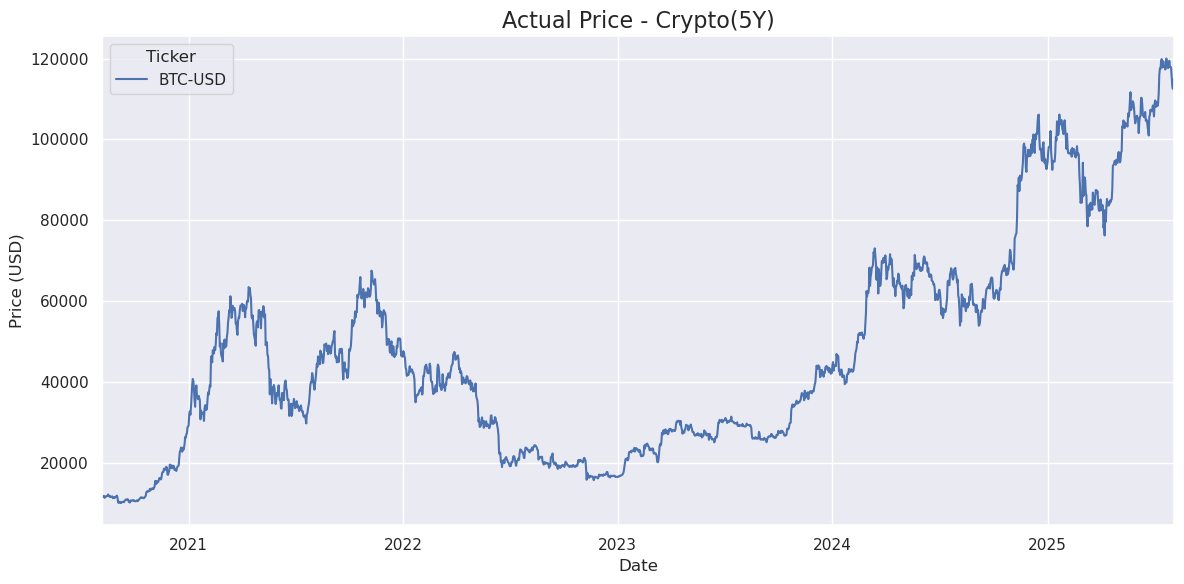

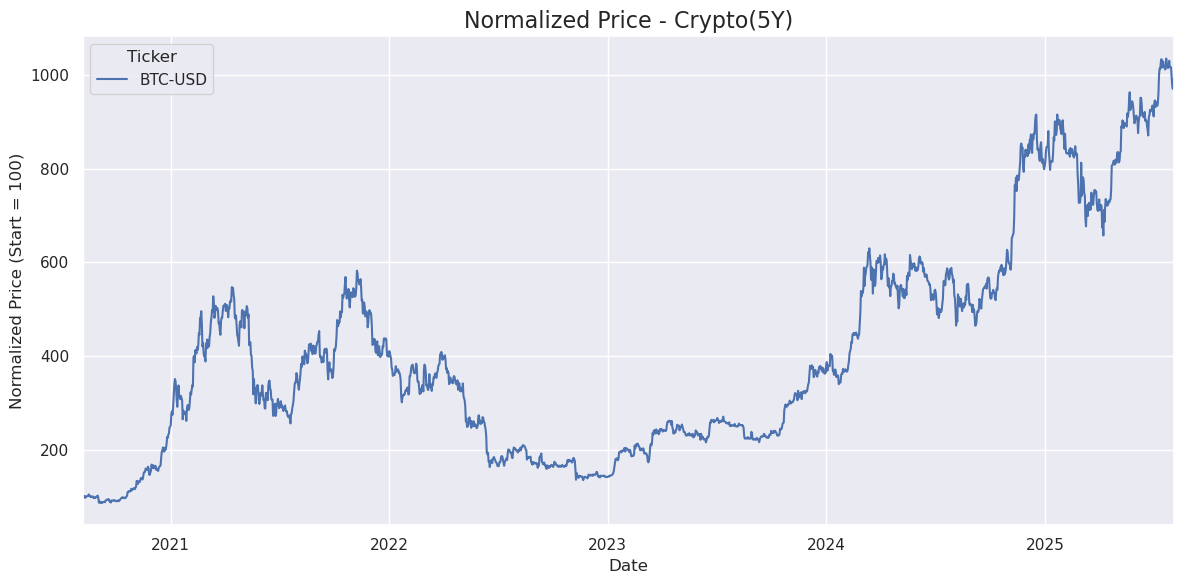

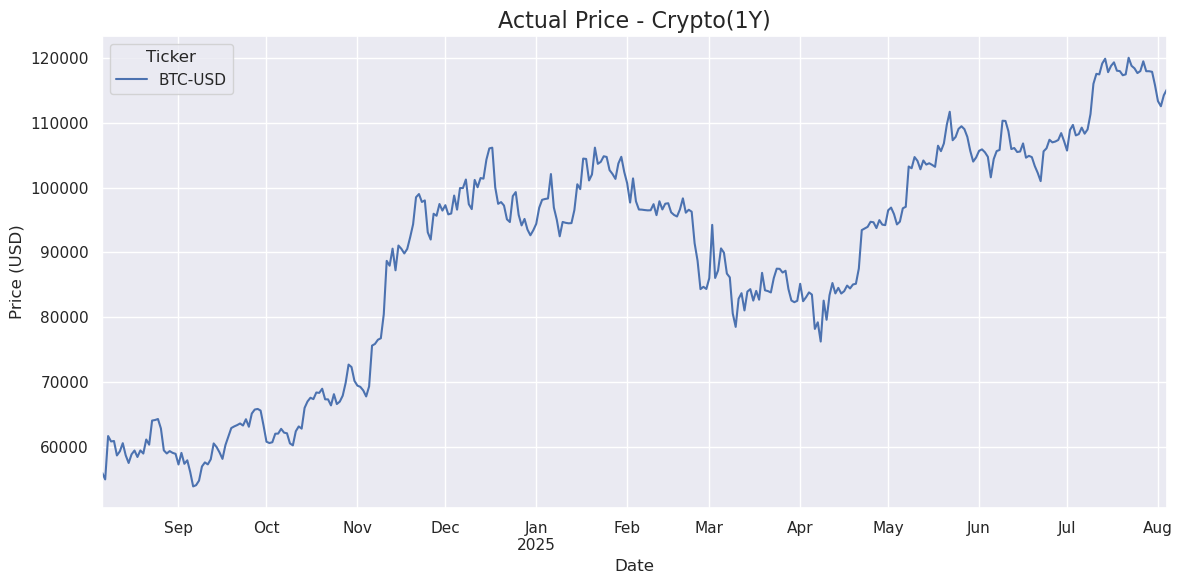

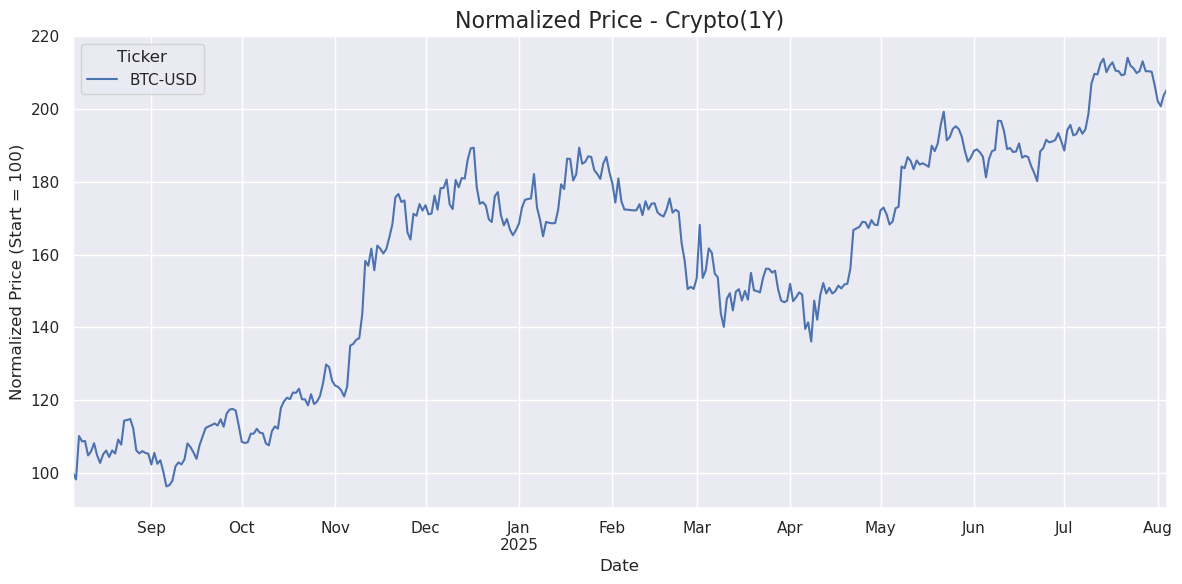

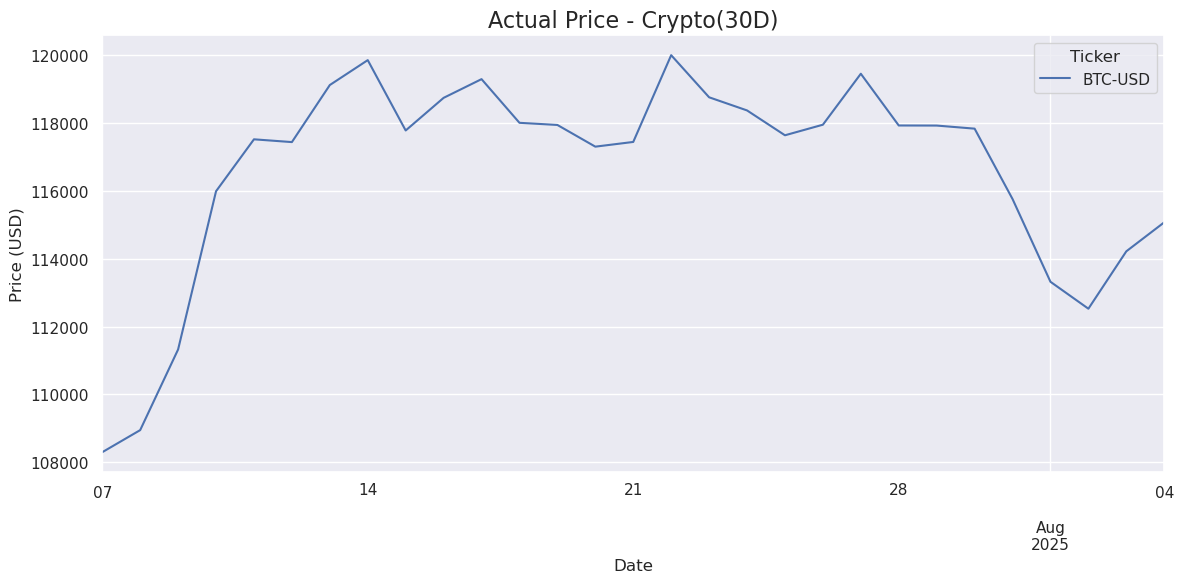

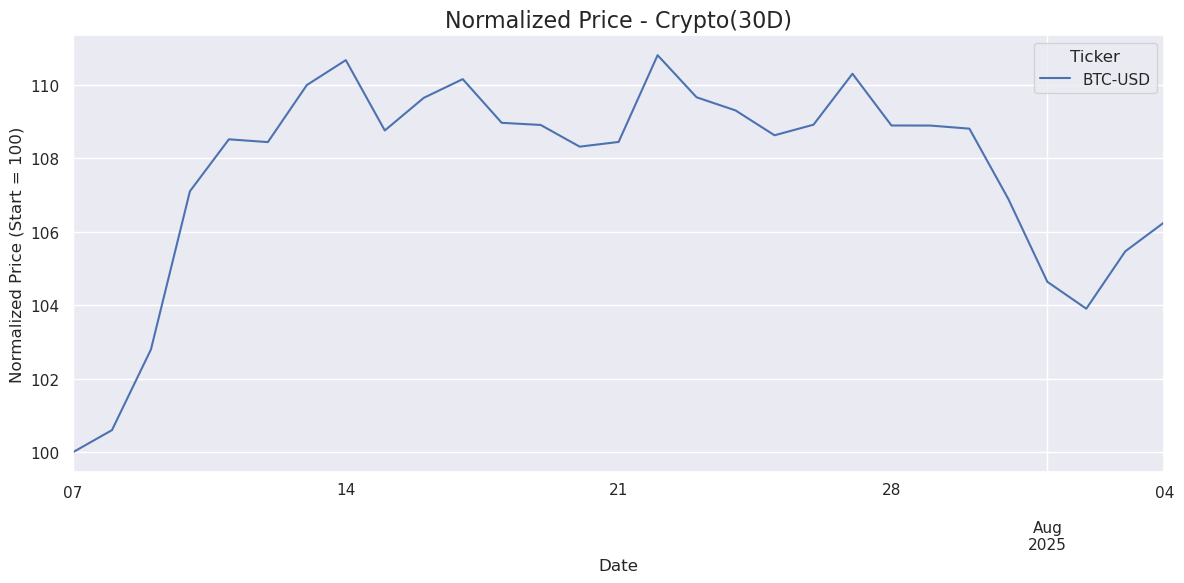

In [52]:
for asset_type, df_subset in [
    ("Equities", df_close_equity),
    ("ETFs", df_close_etf),
    ("Crypto", df_close_crypto)  
]:
    for window in ['5y', '1y', '30d']:
        plot_prices(df_subset, asset_type, window=window, normalize=False, save=True)
        plot_prices(df_subset, asset_type, window=window, normalize=True, save=True)

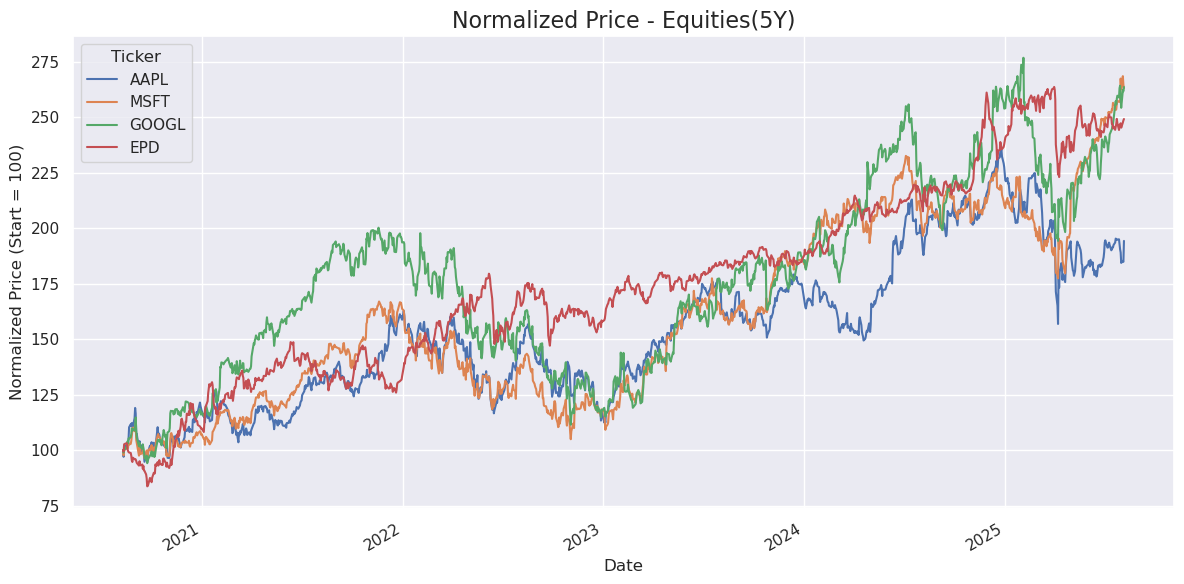

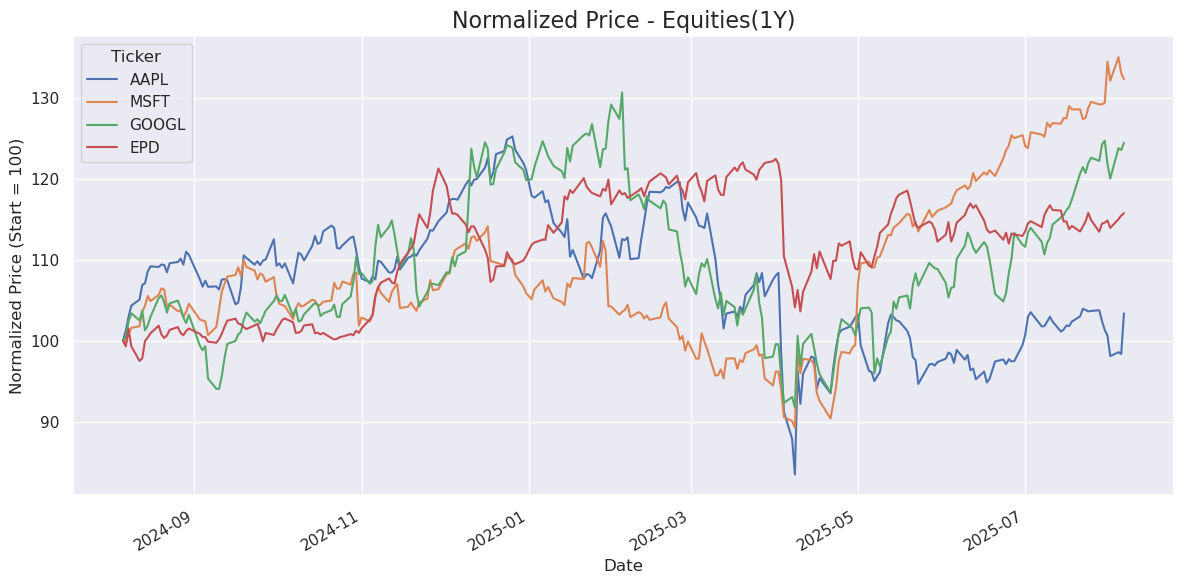

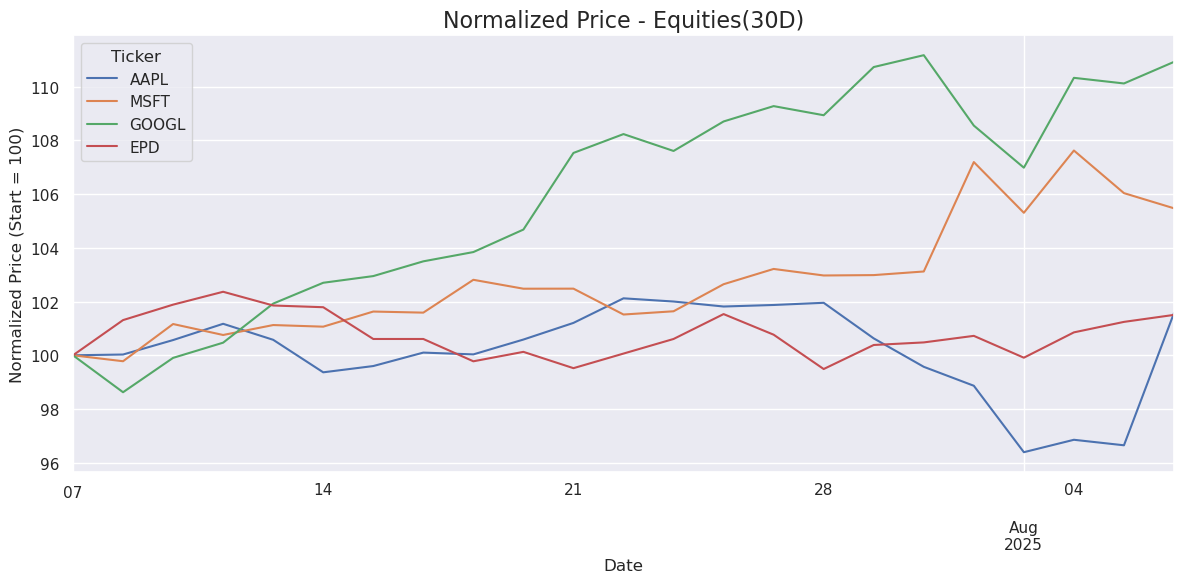

In [53]:
# Toggle normalized views for 3 time windows
for window in ['5y', '1y', '30d']:
    plot_prices(df_close_equity, "Equities", window=window, normalize=True)

In [56]:
#Define Stats Function

def compute_return_stats(daily_returns, asset_type=None, save=False):
    #Computes volatility, skewness, and kurtosis for a daily return DataFrame.
    
    stats = pd.DataFrame(index=daily_returns.columns)
    stats['Volatility'] = daily_returns.std()
    stats['Skewness'] = daily_returns.skew()
    stats['Kurtosis'] = daily_returns.kurt()
    
    if asset_type:
        stats['Type'] = asset_type
        
    stats = stats.round(4)
    
    if save:
        filename = f"{asset_type.lower()}_daily_return_stats.csv" if asset_type else "daily_return_stats.csv"
        stats.to_csv(f"{PROCESSED_DATA_DIR}{filename}")
        
    return stats

In [57]:
#Compute Daily Returns for Each Asset Group
#Equity
daily_returns_equity = df_close_equity.pct_change(fill_method=None).dropna()
stats_equity = compute_return_stats(daily_returns_equity, asset_type='Equity', save=True)

#ETF
daily_returns_etf = df_close_etf.pct_change(fill_method=None).dropna()
stats_etf = compute_return_stats(daily_returns_etf, asset_type='ETF', save=True)

#Crypto
daily_returns_crypto = df_close_crypto.pct_change(fill_method=None).dropna()
stats_crypto = compute_return_stats(daily_returns_crypto, asset_type='Crypto', save=True)

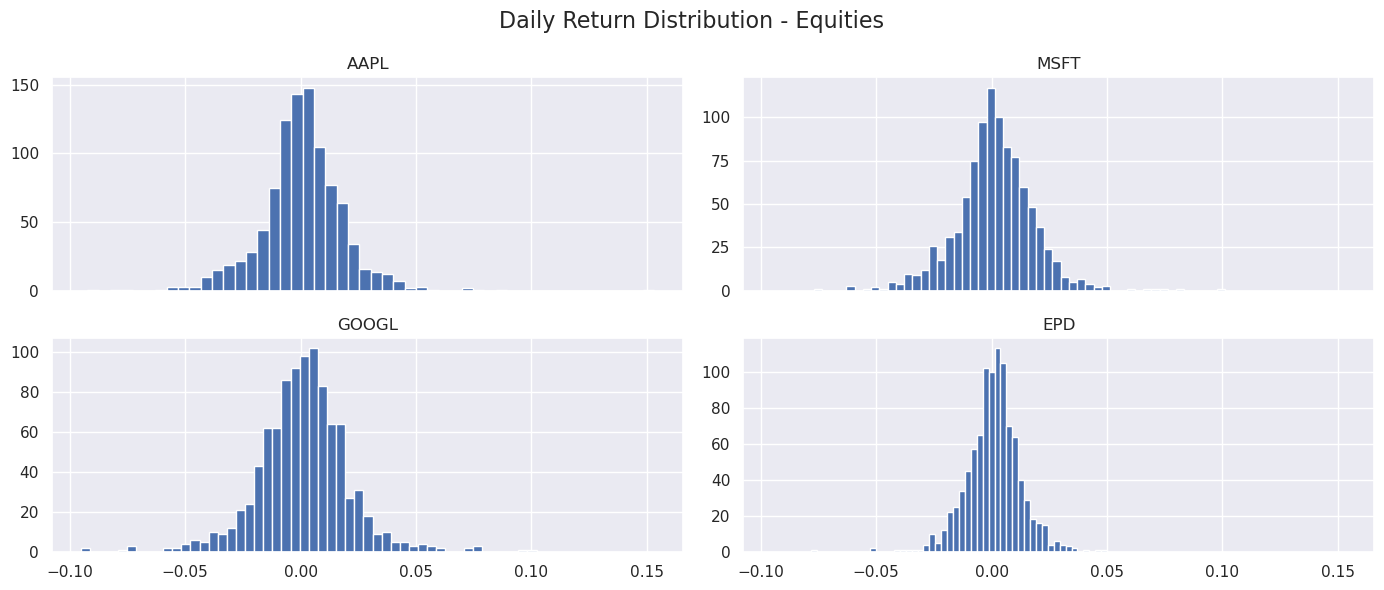

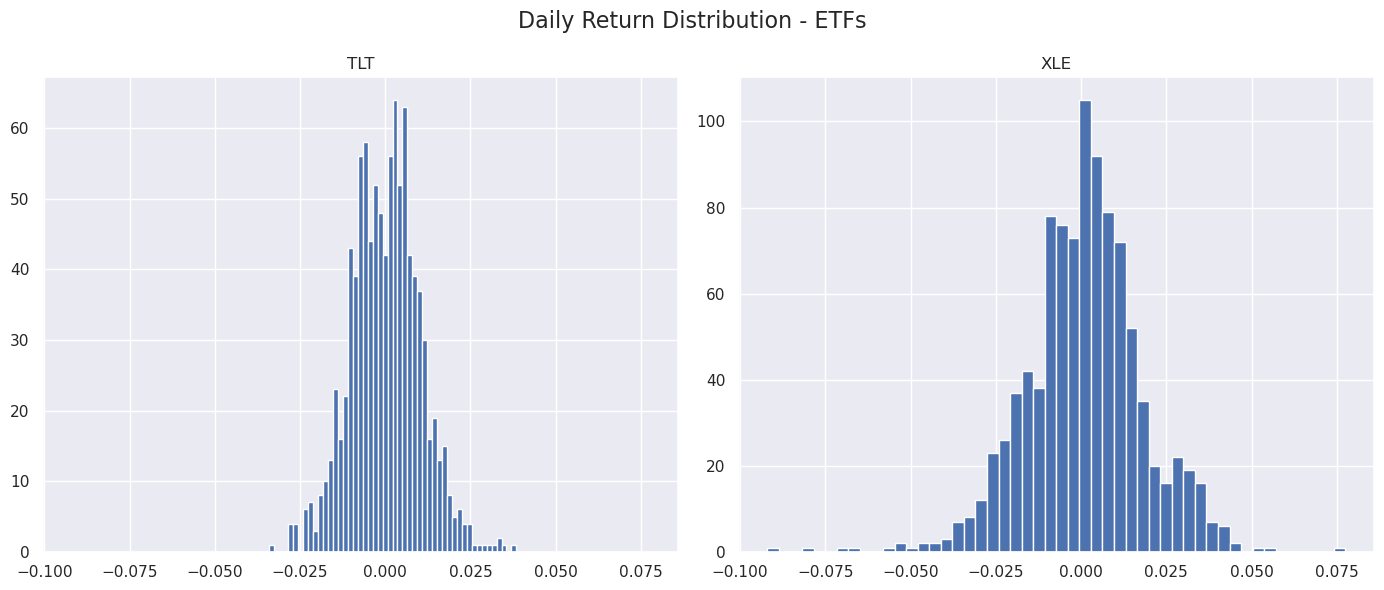

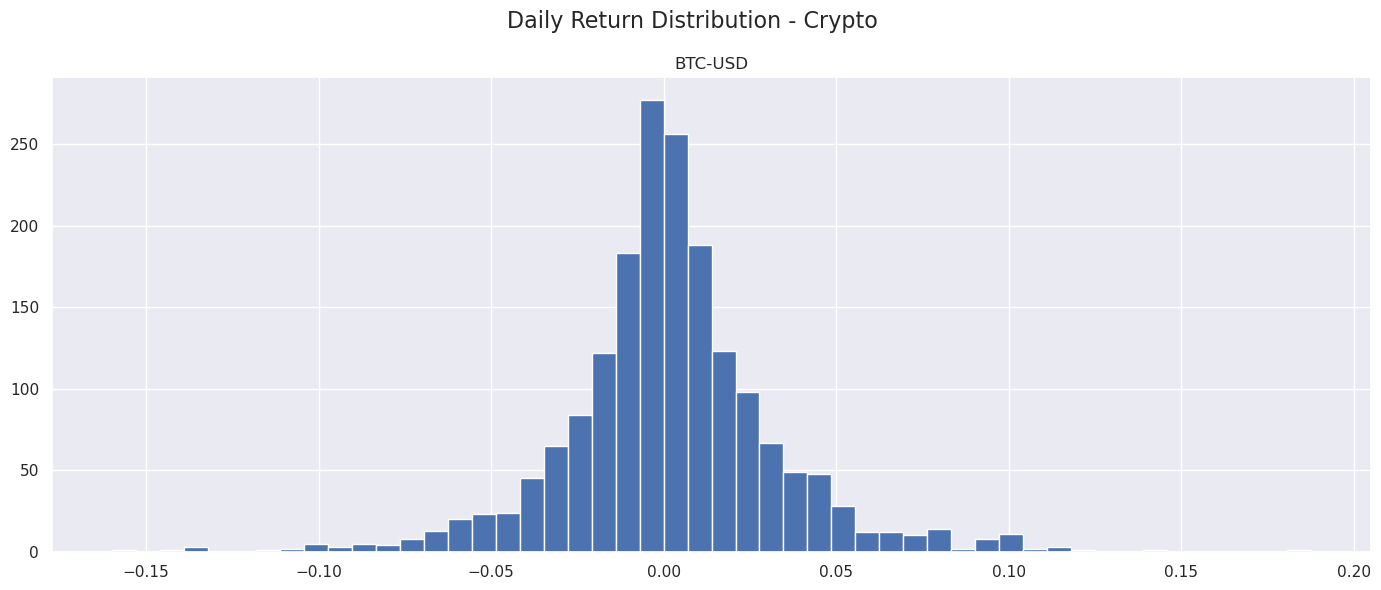

In [58]:
#plot Return distributions
for title, df in [
    ("Equities", daily_returns_equity),
    ("ETFs", daily_returns_etf),
    ("Crypto", daily_returns_crypto)
]:
    df.hist(bins=50, figsize=(14,6), sharex=True)
    plt.suptitle(f"Daily Return Distribution - {title}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [59]:
#Create and combine all stats into one table
stats_all = pd.concat([stats_equity, stats_etf, stats_crypto])
stats_all.to_csv(f"{PROCESSED_DATA_DIR}daily_return_stats_all_assets.csv")

#Display in notebook
display(stats_all)

,Volatility,Skewness,Kurtosis,Type
AAPL,0.0185,0.4253,6.9738,Equity
MSFT,0.0173,0.1537,3.1365,Equity
GOOGL,0.0200,0.0366,3.4173,Equity
EPD,0.0117,-0.4038,3.5270,Equity
TLT,0.0101,0.1100,0.4143,ETF
XLE,0.0173,-0.2751,1.9858,ETF
BTC-USD,0.0312,0.1238,3.4900,Crypto


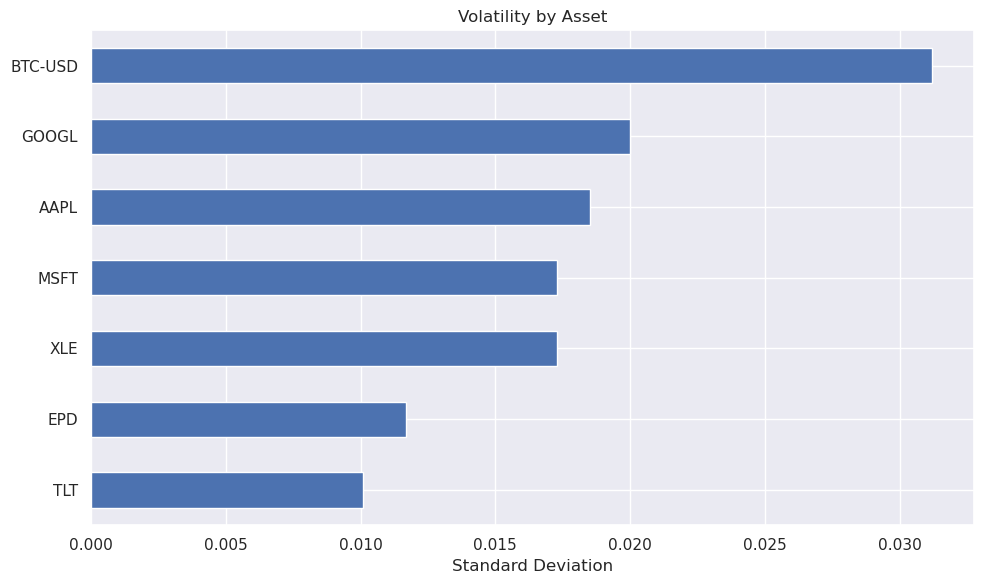

In [60]:
#plot Volatility
stats_all.sort_values("Volatility").plot(kind="barh", y="Volatility", figsize=(10,6), legend=False)
plt.title("Volatility by Asset")
plt.xlabel("Standard Deviation")
plt.grid(True)
plt.tight_layout()
plt.show()

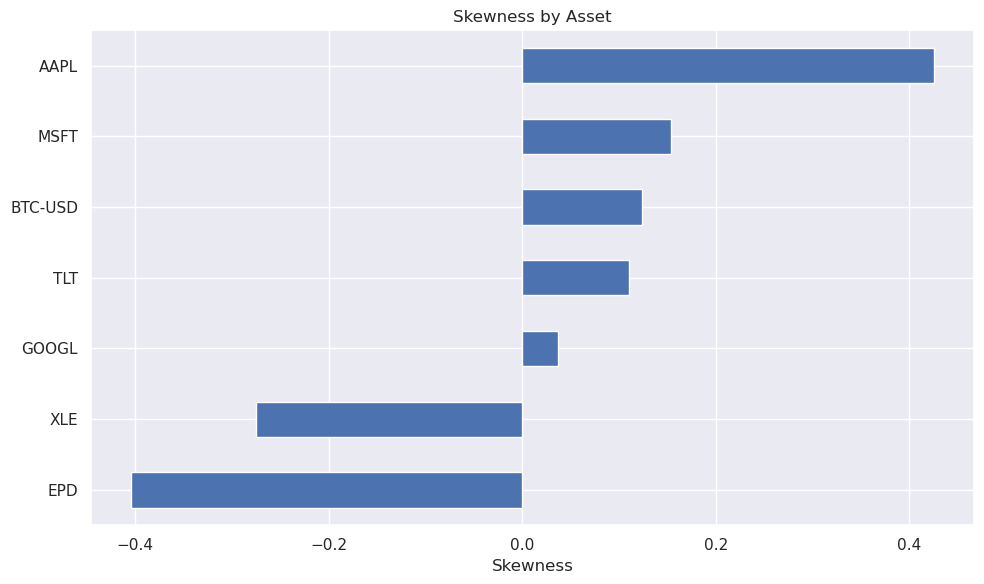

In [61]:
#Plot Skewness
stats_all.sort_values("Skewness").plot(kind='barh', y="Skewness", figsize=(10,6), legend=False)
plt.title("Skewness by Asset")
plt.xlabel("Skewness")
plt.grid(True)
plt.tight_layout()
plt.show()

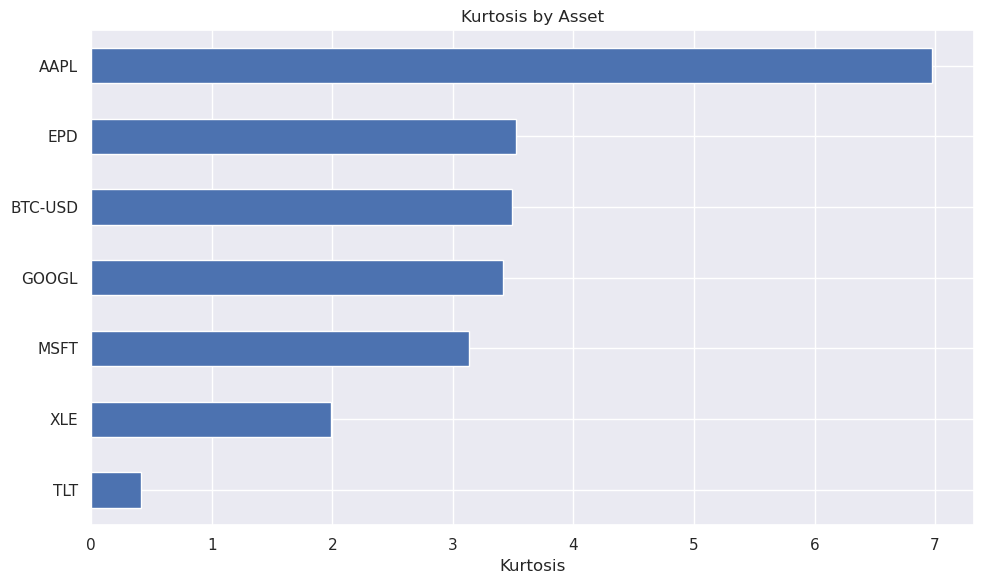

In [62]:
#Plot Kurtosis
stats_all.sort_values("Kurtosis").plot(kind='barh', y="Kurtosis", figsize=(10,6), legend=False)
plt.title("Kurtosis by Asset")
plt.xlabel("Kurtosis")
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
#correlation Heatmap
def plot_correlation_heatmap(returns, title):
    corr = returns.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Correlation Heatmap - {title}")
    plt.tight_layout()
    plt.show()

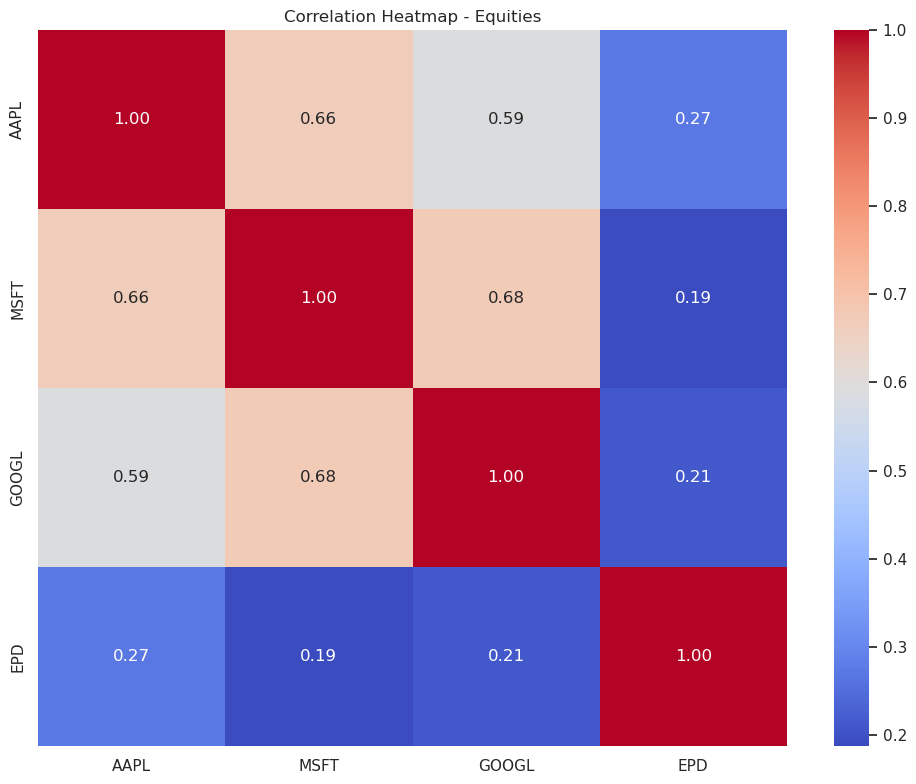

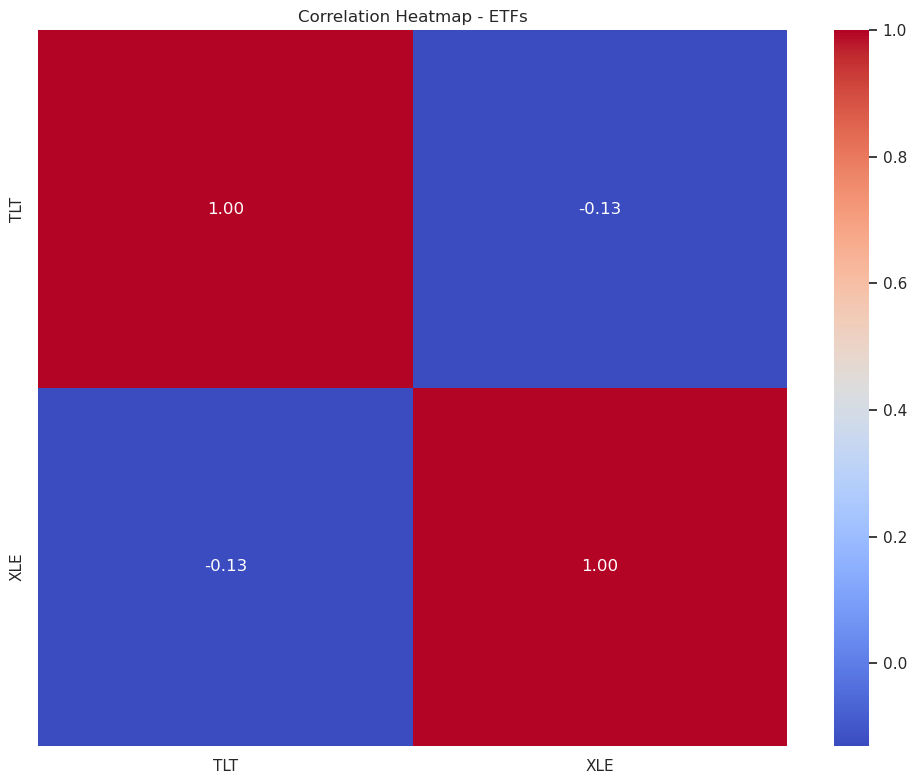

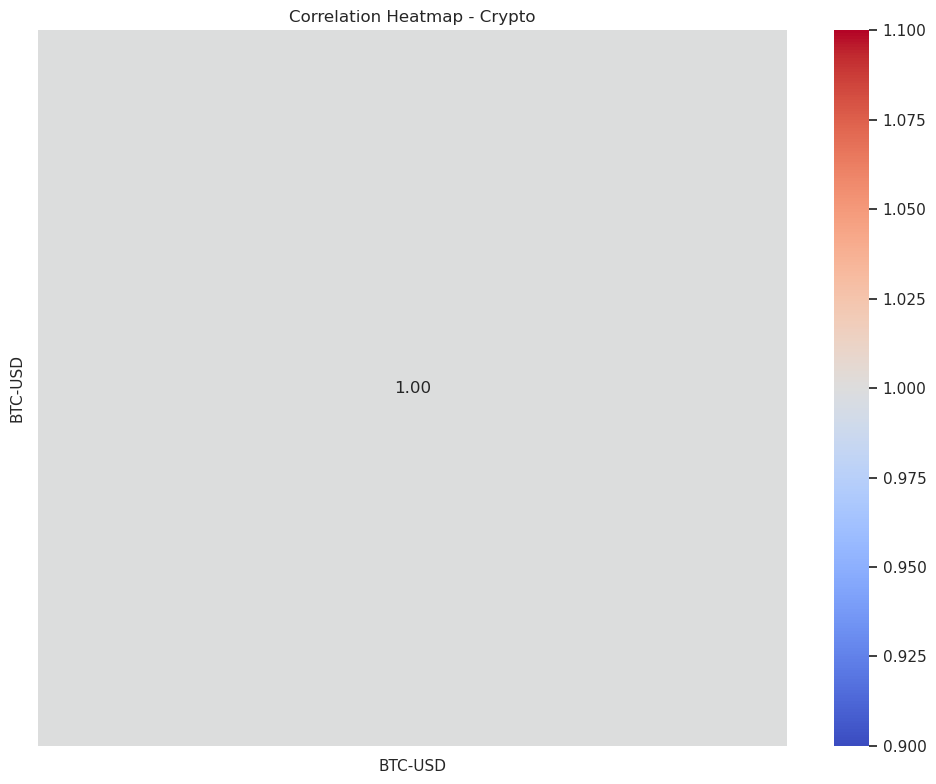

In [64]:
plot_correlation_heatmap(daily_returns_equity, "Equities")
plot_correlation_heatmap(daily_returns_etf, "ETFs")
plot_correlation_heatmap(daily_returns_crypto, "Crypto")

In [ ]:
#Rolling Volatility
volatility = daily_returns.rolling(window=30).std()
volatility.plot(figsize=(14,6))
plt.title("30-Day Rolling Volatility", fontsize=16)
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [ ]:
#Cumulative Returns
cumulative_returns = (1 + daily_returns).cumprod()
cumulative_returns.plot(figsize=(14,7))
plt.title("Cumulative Returns",fontsize=16)
plt.ylabel("Growth of $1 Investment")
plt.xlabel("Date")
plt.grid(True)
plt.legent(title="Ticker")
plt.tight_layout()
plt.show()

In [ ]:
#Sharpe Ratio 
#assume risk-free rate is 0 for simplicity
sharpe_ratios = daily_returns.mean()/daily_returns.std()
print("Sharpe Ratios:\n", sharpe_ratios.sort_values(ascending=False))